## 1. Import Required Python Modules

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

## 2. Load and Preprocess Input Image

In [ ]:
model = resnet50.ResNet50(weights='imagenet')
img_path = tf.keras.utils.get_file('cat2.png',
    'https://images.unsplash.com/photo-1574144611937-0df059b5ef3e?w=600&auto=format&fit=crop&q=60&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MTR8fGNhdHxlbnwwfHwwfHx8MA%3D%3D')

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
input_img = resnet50.preprocess_input(np.expand_dims(img_array.copy(), axis=0))
input_tensor = tf.convert_to_tensor(input_img, dtype=tf.float32)

53322/53322 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 3. Generate Adversarial Example Using FGSM

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    label = tf.argmax(prediction[0])
    loss = loss_object(tf.one_hot([label], 1000), prediction)

epsilon = 0.05
gradient = tape.gradient(loss, input_tensor)
adv_input = tf.clip_by_value(input_tensor + epsilon * tf.sign(gradient), -1, 1)

print("Original Prediction:", resnet50.decode_predictions(prediction.numpy())[0][0])
print("Adversarial Prediction:", resnet50.decode_predictions(model(adv_input).numpy())[0][0])

Original Prediction: ('n02124075', 'Egyptian_cat', np.float32(0.7097982))
Adversarial Prediction: ('n02840245', 'binder', np.float32(0.03708627))


## 4. Grad-CAM Function and Visualization Utilities

In [ ]:
def compute_gradcam(model, img_tensor, layer_name='conv5_block3_out'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)[0]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def show_side_by_side_gradcam(original, adversarial, img_array, titles):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, heatmap in enumerate([original, adversarial]):
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed = cv2.addWeighted(np.uint8(img_array), 0.6, heatmap, 0.4, 0)
        axes[i].imshow(superimposed)
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

## 5. Compute and Visualize Grad-CAM for Original and Adversarial Images

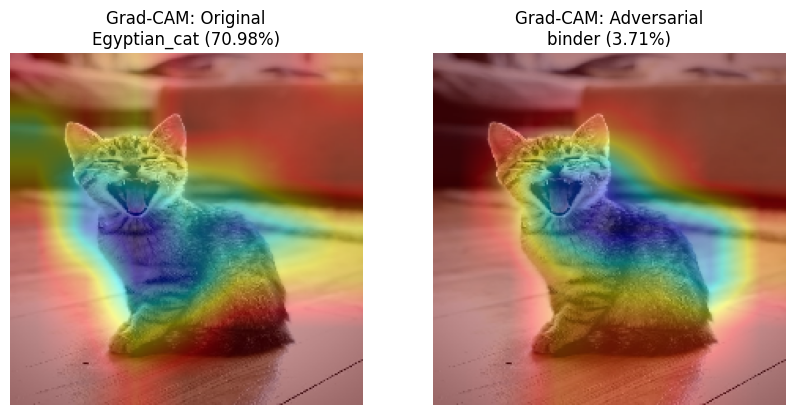

In [ ]:
# Compute Grad-CAM heatmaps
heatmap_orig = compute_gradcam(model, input_tensor)
heatmap_adv = compute_gradcam(model, adv_input)

# Get class labels and confidences
pred_orig = model(input_tensor)
label_orig, conf_orig = resnet50.decode_predictions(pred_orig.numpy())[0][0][1:]
conf_orig = pred_orig.numpy().max() * 100

pred_adv = model(adv_input)
label_adv, conf_adv = resnet50.decode_predictions(pred_adv.numpy())[0][0][1:]
conf_adv = pred_adv.numpy().max() * 100

# Update titles to include class and confidence
titles = [
    f'Grad-CAM: Original\n{label_orig} ({conf_orig:.2f}%)',
    f'Grad-CAM: Adversarial\n{label_adv} ({conf_adv:.2f}%)'
]

# Show side-by-side Grad-CAM with predictions
show_side_by_side_gradcam(heatmap_orig, heatmap_adv, img_array, titles)


## 6. Integrated Gradients Functions and Visualization Utilities

In [ ]:
def interpolate(baseline, input_tensor, steps=50):
    alphas = tf.linspace(0.0, 1.0, steps + 1)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    return baseline + alphas_x * (input_tensor - baseline)

def integrated_gradients(model, input_tensor, target_index, steps=50, baseline=None):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape)
    interpolated = interpolate(baseline, input_tensor, steps)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        logits = model(interpolated)
        probs = logits[:, target_index]
    grads = tape.gradient(probs, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    ig = (input_tensor - baseline) * avg_grads
    return tf.reduce_sum(tf.abs(ig), axis=-1)[0]

def show_side_by_side_ig(ig_orig, ig_adv, titles):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, ig_map in enumerate([ig_orig, ig_adv]):
        axes[i].imshow(ig_map, cmap='plasma')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

## 7. Compute and Visualize IG for Original and Adversarial Images

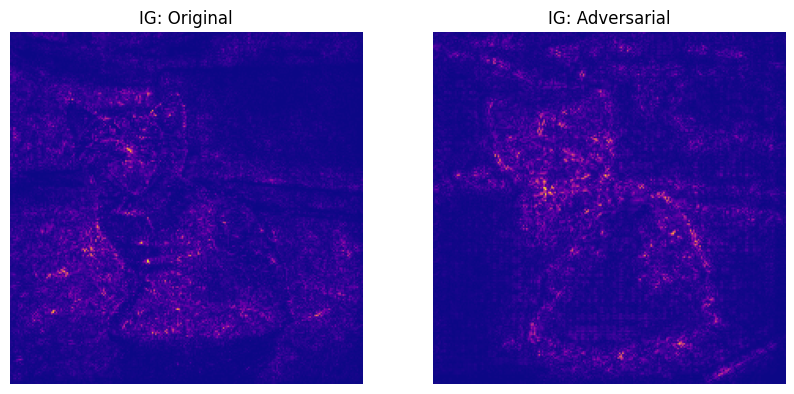

In [ ]:
target_class_orig = tf.argmax(model(input_tensor)[0])
target_class_adv = tf.argmax(model(adv_input)[0])

ig_orig = integrated_gradients(model, input_tensor, target_class_orig)
ig_adv = integrated_gradients(model, adv_input, target_class_adv)

titles = ['IG: Original', 'IG: Adversarial']

show_side_by_side_ig(ig_orig, ig_adv, titles)

## 8. Compute and Visualize Grad-CAM Using Softmax

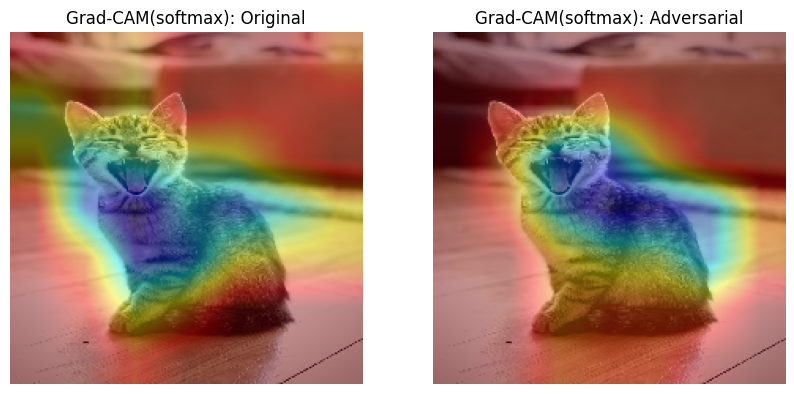

In [ ]:
def compute_gradcam_softmax(model, img_tensor, layer_name='conv5_block3_out'):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        probs = tf.nn.softmax(predictions)
        loss = probs[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)[0]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

heatmap_softmax_orig = compute_gradcam_softmax(model, input_tensor)
heatmap_softmax_adv = compute_gradcam_softmax(model, adv_input)
titles = ['Grad-CAM(softmax): Original', 'Grad-CAM(softmax): Adversarial']
show_side_by_side_gradcam(heatmap_softmax_orig, heatmap_softmax_adv, img_array, titles)

## 9. Compute and Visualize Integrated Gradients Using Pre Softmax

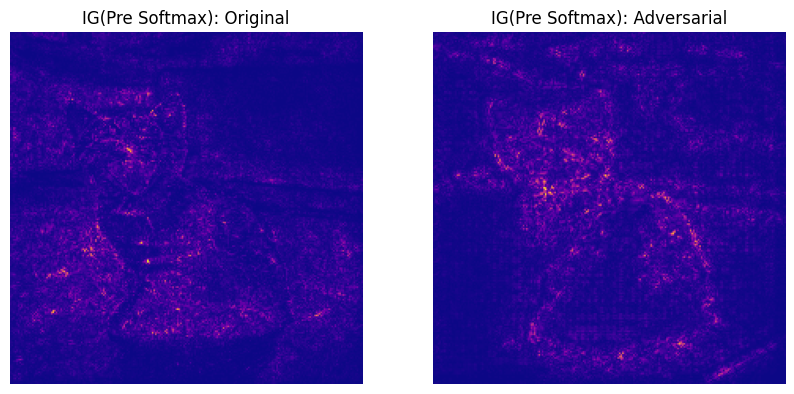

In [ ]:
def ig_logits(model, input_tensor, target_index, steps=50, baseline=None):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape)
    interpolated = interpolate(baseline, input_tensor, steps)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        logits = model(interpolated)  # ← no softmax
        class_prob = logits[:, target_index]
    grads = tape.gradient(class_prob, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    ig = (input_tensor - baseline) * avg_grads
    return tf.reduce_sum(tf.abs(ig), axis=-1)[0]


ig_orig_softmax = ig_logits(model, input_tensor, target_class_orig)
ig_adv_softmax = ig_logits(model, adv_input, target_class_adv)
titles = ['IG(Pre Softmax): Original', 'IG(Pre Softmax): Adversarial']
show_side_by_side_ig(ig_orig_softmax, ig_adv_softmax, titles)

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
72621/72621 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


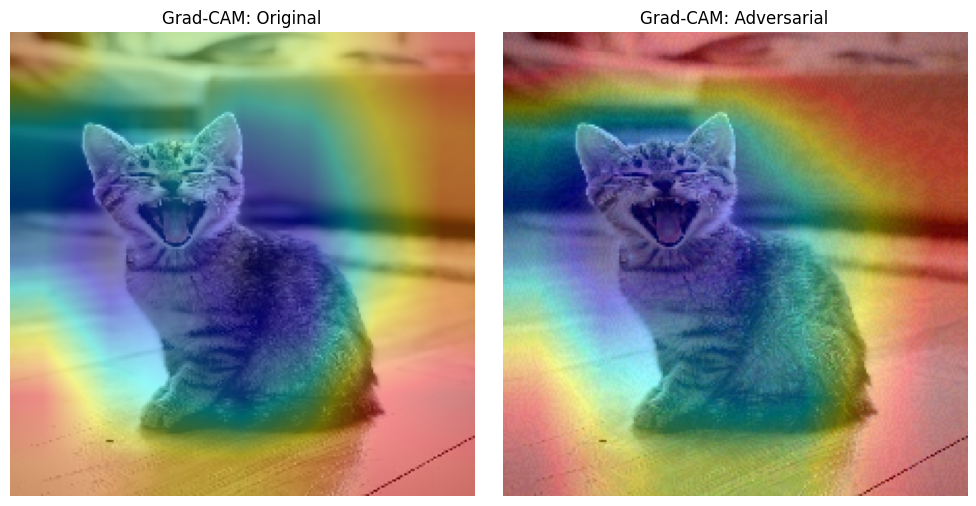

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load MobileNetV2
model = mobilenet_v2.MobileNetV2(weights='imagenet')
model.trainable = False

# Download and preprocess image
img_path = tf.keras.utils.get_file('cat.png', 'https://images.unsplash.com/photo-1574144611937-0df059b5ef3e?w=600')
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
input_img = mobilenet_v2.preprocess_input(np.expand_dims(img_array.copy(), axis=0))
input_tensor = tf.convert_to_tensor(input_img)

# FGSM Attack
loss_object = tf.keras.losses.CategoricalCrossentropy()
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)
    label = tf.argmax(prediction[0])
    loss = loss_object(tf.one_hot([label], 1000), prediction)

gradient = tape.gradient(loss, input_tensor)
signed_grad = tf.sign(gradient)
epsilon = 0.05
adv_img_tensor = input_tensor + epsilon * signed_grad
adv_img_tensor = tf.clip_by_value(adv_img_tensor, -1, 1)  # for MobileNetV2 input range

# Grad-CAM Utility
def get_gradcam_heatmap(img_tensor, model, last_conv_layer_name="Conv_1", pred_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM Visualization
def overlay_gradcam(original_img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img.astype('uint8'), 1 - alpha, jet, alpha, 0)
    return superimposed_img

# Prepare images
original = np.uint8((img_array / 255.0) * 255)
adv_img = adv_img_tensor.numpy()[0]
adv_img = np.uint8(((adv_img + 1.0) / 2.0) * 255)

# Generate heatmaps
heatmap_orig = get_gradcam_heatmap(input_tensor, model)
heatmap_adv = get_gradcam_heatmap(adv_img_tensor, model)

# Overlay and plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(overlay_gradcam(original, heatmap_orig))
axs[0].set_title("Grad-CAM: Original")
axs[1].imshow(overlay_gradcam(adv_img, heatmap_adv))
axs[1].set_title("Grad-CAM: Adversarial")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()
